In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set your dataset path inside Google Drive
dataset_path = "/content/drive/MyDrive/Concrete Crack Images for Classification"
positive_dir = f"{dataset_path}/Positive"
negative_dir = f"{dataset_path}/Negative"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(Path(image_dir).glob("*.jpg")), name="Filepath").astype(str)
    labels = pd.Series(label, name="Label", index=filepaths.index)
    return pd.concat([filepaths, labels], axis=1)

positive_df = generate_df(positive_dir, "POSITIVE")
negative_df = generate_df(negative_dir, "NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
train_df, test_df = train_test_split(all_df.sample(6000, random_state=1), train_size=0.7, random_state=1)

In [5]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    subset='validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(120, 120),
    color_mode='grayscale',
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [6]:
inputs = tf.keras.Input(shape=(120, 120, 1))
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673 (2.63 KB)

 Trainable params: 673 (2.63 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=8,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 1450s 14s/step - accuracy: 0.5216 - loss: 0.6914 - val_accuracy: 0.5143 - val_loss: 0.6853
Epoch 2/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 303ms/step - accuracy: 0.5238 - loss: 0.6883 - val_accuracy: 0.4857 - val_loss: 0.6847
Epoch 3/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 309ms/step - accuracy: 0.5865 - loss: 0.6752 - val_accuracy: 0.5738 - val_loss: 0.6645
Epoch 4/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 33s 312ms/step - accuracy: 0.6463 - loss: 0.6529 - val_accuracy: 0.7226 - val_loss: 0.6191
Epoch 5/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 309ms/step - accuracy: 0.6817 - loss: 0.6314 - val_accuracy: 0.7429 - val_loss: 0.5959
Epoch 6/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 40s 301ms/step - accuracy: 0.6921 - loss: 0.6051 - val_accuracy: 0.7536 - val_loss: 0.5688
Epoch 7/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 33s 309ms/step - accuracy: 0.7451 - loss: 0.5723 - val_accuracy: 0.7845 - val_loss: 0.5525
Epoch 8/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - accuracy: 0.7893 - loss: 0.5656 - 

Test Loss: 0.5692 | Test Accuracy: 76.44%
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step


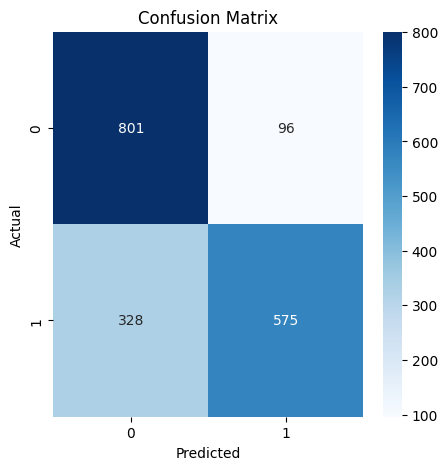

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.71      0.89      0.79       897
    POSITIVE       0.86      0.64      0.73       903

    accuracy                           0.76      1800
   macro avg       0.78      0.76      0.76      1800
weighted avg       0.78      0.76      0.76      1800



In [8]:
results = model.evaluate(test_data, verbose=0)
print(f"Test Loss: {results[0]:.4f} | Test Accuracy: {results[1]*100:.2f}%")

# Prediction
y_pred = (model.predict(test_data) >= 0.5).astype(int).squeeze()
cm = confusion_matrix(test_data.labels, y_pred)
clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", clr)

In [9]:
# Save the model in HDF5 format
model.save("crack_detection_model.h5")

In [10]:
from google.colab import files
files.download("crack_detection_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/crack_detection_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open("crack_detection_model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmps7sh0fzh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 120, 120, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133850486306192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133850486306960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133850443707216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133850443709136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133850443708560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133850443709904: TensorSpec(shape=(), dtype=tf.resource, name=None)
